# Bayesian Linear Regression

### Improvement on MLE
Maximum likelihood estimation gave us a point estimate of the probability that we observed what we observed. What would be better is to gain a probability distribution instead of a point estimate.

### How?
First we assume that we know a bit about this function before we take any samples (make any observations) and incorporate this knowledge in a $\textbf{prior}$ distribution.   
We can assume a prior distribution on the weights and call it the precision $(\alpha)$, which is the inverse of the variance:
$$
\alpha = \frac{1}{\sigma^2}
$$
This is a measure of uncertainty, where the prior believes the weights that will maximise the likelihood must be around 0, with a precision of $\alpha$.

#### Combining prior and likelihood
Now we have the prior and the likelihood (calculated in MLE), we can use Bayes rule to combine the two to make the posterior distribution. $\text{posterior} = \text{likelihood} \times \text{prior}$
Which outlines what weights we have $\textbf{after}$ we see the data. Now we have the posterior
$$
\mathbb{P}(\textbf{w}|\textbf{x}_{1:n}, y_{1:n}, \alpha, \beta) = \mathcal{N}(\textbf{w}|\textbf{m}, \textbf{S}),
$$
where the covariance matrix $\textbf{S}$ is given by 
$$
\textbf{S} = (\beta\Phi^T\Phi + \alpha\textbf{I})^{-1}
$$
and the mean vector
$$
\textbf{m} = \beta\textbf{S}\Phi^T\textbf{y}_{1:n}
$$
#### What do we have now?
After loads of algebra, we now have a model that we can use to gain a predictive posterior distribution and predictive uncertainty. 
$$
\mathbb{P}(y|\textbf{x}, \textbf{x}_{1:n},\textbf{y}_{1:n},\alpha,\beta) = \mathcal{N}(y|m(\textbf{x}),s^2(\textbf{x})),
$$
where
$$
\begin{aligned}
m(\textbf{x}) = \textbf{m}^T\phi(\textbf{x}) \\
s^2(\textbf{x}) = \phi(\textbf{x})^T\textbf{S}\phi(\textbf{x}) + \frac{1}{\beta}
\end{aligned}
$$

The latter is the uncertainty of the model, where $\phi(\textbf{x})^T\textbf{S}\phi(\textbf{x})$ is the epistemic uncertainty, and $\frac{1}{\beta}$ is the measurement noise.

#### How do we translate this into code?
We need to code functions for:
* The prior
* The posterior
* The posterior distribution

We do not have to calculate the likelihood explicitly because we assume it to be Gaussian, we can therefore express the posterior, which is the product of the likelihood times the prior, in terms of $\textbf{m}$ and $\textbf{S}$ which is what we need. 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import data_gen

In [76]:
def prior(alpha: float, N: int) -> (np.array, np.array):
    """
    Computes the prior distribution from the precision (alpha) and the number of samples N
    """
    m0 = np.zeros(N)
    s0 = 1/alpha * np.eye(N)
    
    return m0, s0
def posterior(Phi: np.array, beta: float, alpha: float, y: np.array) -> (np.array, np.array):
    """
    Computes the mean and covariance of the posterior distribution.
    """
    S_inv = beta * Phi.T.dot(Phi) + alpha * np.eye(Phi.shape[1])
    S = np.linalg.inv(S_inv)
    m = beta * S @ Phi.T @ y
    return m, S

def posterior_predictive(Phi: np.array, beta: float, m: np.array, S: np.array) -> (np.array, np.array, np.array):
    y = Phi.dot(m).ravel() # Reference [1]
    y_epistemic = np.sum((Phi @ S) * Phi, axis=1)
    y_uncertainty = y_epistemic + (1/beta)
    
    return y, y_epistemic, y_uncertainty

#### Formulate basis functions and design matrix

In [77]:
class RBF:
    """
    Radial Basis Function
    """
    def __init__(self, X, ell):
        self.X = X
        self.ell = ell
        self.num_basis = X.shape[0]

    def __call__(self, x):
        return np.exp(-0.5 * (x - self.X) ** 2 / self.ell ** 2).flatten()

def matrixIJ(X, phi):
    """
    Creates a matrix composed of the number of observations I and the number of basis functions J. 
    """
    num_observations = X.shape[0]
    num_basis = phi.num_basis
    Phi = np.zeros((num_observations, num_basis))
    for i in range(num_observations):
        Phi[i, :] = phi(X[i, :])
    return Phi

In [91]:
ell = 0.1
alpha = 10
beta = 20
num_basis = 10
num_observations = 1
sigma = 0.1**2

# Generate Data
X_data = np.random.uniform(-1, 1, num_observations)[:, None]
y_data = data_gen.data(X_data, sigma)

# Get design matrix 
Xc = np.linspace(-1, 1, num_basis)
phi = RBF(Xc, ell)
Phi = matrixIJ(X_data, phi)

# Compute mean and covariance of posterior 
m, S = posterior(Phi, beta, alpha, y_data)

# Get design matrix for testing
Xp = np.linspace(-1, 1, 100)[:, None]
Phi_p = matrixIJ(Xp, phi)

# Compute predictive posterior
y, y_epi, y_err = posterior_predictive(Phi_p, beta, m, S) 

y_epi = np.sqrt(y_epi)
y_err = np.sqrt(y_err)

y_epi_lower = y - 2*y_epi
y_epi_upper = y + 2*y_epi

y_err_lower = y - 2*y_err
y_err_upper = y + 2*y_err

### Plotting

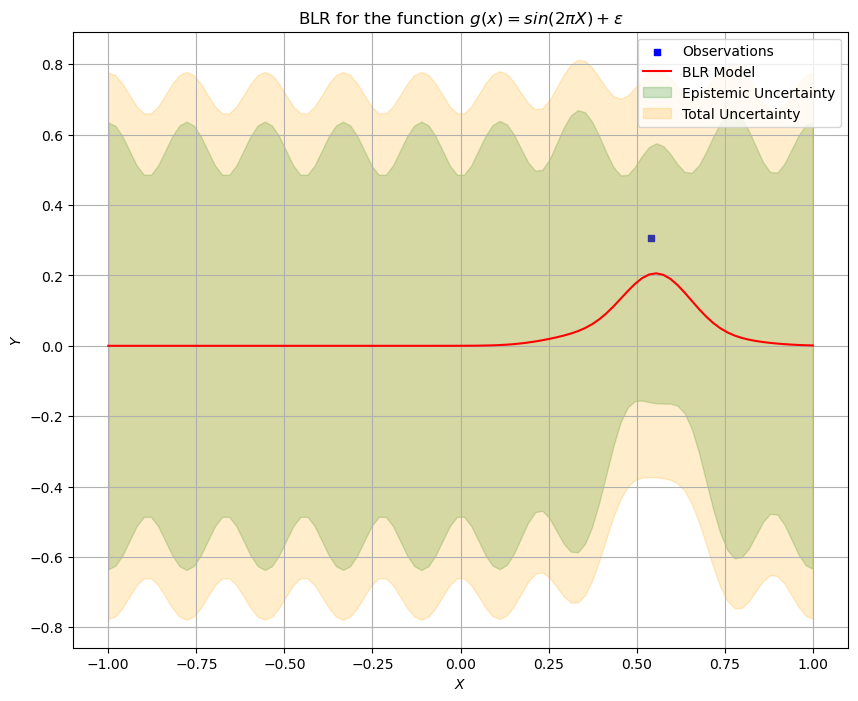

In [92]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(X_data, y_data, marker="s", s=20, color="b", label='Observations')
ax.plot(Xp, y, color='r', label='BLR Model')
ax.fill_between(Xp.flatten(), y_epi_lower, y_epi_upper, color='green', alpha=0.2, label="Epistemic Uncertainty")
ax.fill_between(Xp.flatten(), y_err_lower, y_err_upper, color='orange', alpha=0.2, label="Total Uncertainty")
ax.set_title("BLR for the function $g(x) = sin(2\pi X) + \epsilon$")
ax.set_xlabel("$X$")
ax.set_ylabel("$Y$")
ax.legend()
ax.grid(True)


### Further Investigation
* We could look at varying hyperparameters such as $\ell$, $\alpha$ or $\beta$ to see what happens to our prediction and its uncertainty.
* We could test the ability of BLR model by upping the noise of the observations $(\sigma^2)$ to see how much the uncertainty grows. 

### Animation increasing the number of observations

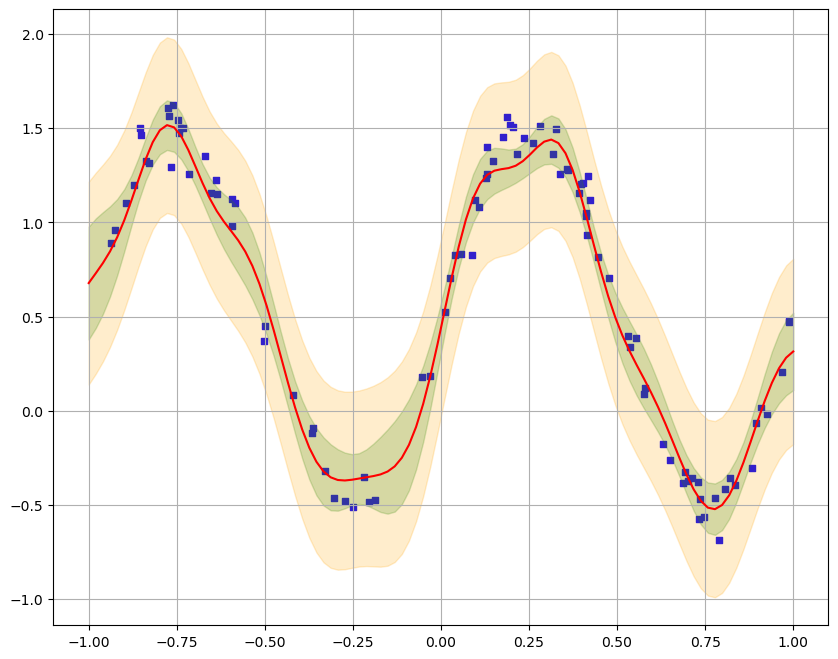

In [108]:
import matplotlib.animation as animation

num_obvs = np.arange(0, 101, 1)

X_datas = []
y_datas = []
ys = []
y_errs_lower = []
y_errs_upper = []
y_epis_lower = []
y_epis_upper = []


sigma = 0.1**2
num_observations = 100

# Generate Data
X_data_master = np.random.uniform(-1, 1, num_observations)[:, None]
y_data_master = data_gen.data(X_data_master, sigma)

for i, obvs in enumerate(num_obvs):
    ell = 0.1
    alpha = 10
    beta = 20
    num_basis = 10
    num_observations = obvs
    sigma = 0.1**2
    
    X_data = X_data_master[0:obvs]
    y_data = y_data_master[0:obvs]
    
    X_datas.append(X_data)
    y_datas.append(y_data)
    
    # Get design matrix 
    Xc = np.linspace(-1, 1, num_basis)
    phi = RBF(Xc, ell)
    Phi = matrixIJ(X_data, phi)
    
    # Compute mean and covariance of posterior 
    m, S = posterior(Phi, beta, alpha, y_data)
    
    # Get design matrix for testing
    Xp = np.linspace(-1, 1, 100)[:, None]
    Phi_p = matrixIJ(Xp, phi)
    
    # Compute predictive posterior
    y, y_epi, y_err = posterior_predictive(Phi_p, beta, m, S) 
    
    y_epi = np.sqrt(y_epi)
    y_err = np.sqrt(y_err)
    
    y_epi_lower = y - 2*y_epi
    y_epi_upper = y + 2*y_epi
    
    y_err_lower = y - 2*y_err
    y_err_upper = y + 2*y_err
    
    ys.append(y)
    y_errs_lower.append(y_err_lower)
    y_errs_upper.append(y_err_upper)
    y_epis_lower.append(y_epi_lower)
    y_epis_upper.append(y_epi_upper)

fig, ax = plt.subplots(figsize=(10, 8))
def animate(i):
    ax.cla()
    ax.scatter(X_datas[i], y_datas[i], marker="s", s=20, color="b", label='Observations')
    ax.plot(Xp, ys[i], color='r', label='BLR Model')
    ax.fill_between(Xp.flatten(), y_epis_lower[i], y_epis_upper[i], color='green', alpha=0.2, label="Epistemic Uncertainty")
    ax.fill_between(Xp.flatten(), y_errs_lower[i], y_errs_upper[i], color='orange', alpha=0.2, label="Total Uncertainty")
    ax.grid(True)
    
    if i == 0:
        ax.set_title("BLR for the function $g(x) = sin(2\pi X) + \epsilon$")
        ax.set_xlabel("$X$")
        ax.set_ylabel("$Y$")
        ax.legend()
        
        
ani = animation.FuncAnimation(fig, animate, repeat=True, frames=len(ys) - 1, interval=50)
# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=1,
                                metadata=dict(artist='JR'),
                                bitrate=1800)
ani.save('anim.gif', writer=writer)
plt.show()

## References

[1 - Warwick University, School of Engineering, Scientific Machine Learning, Lecture 3 - Bayesian Linear Regression](https://moodle.warwick.ac.uk/pluginfile.php/3814741/mod_resource/content/7/ES98E-L3-LinearRegression.html)